In [1]:
import logging
import torch
import numpy as np
import matplotlib.pyplot as plt

from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.proc.dense.process import Dense
from lava.proc.sdn.process import ActivationMode
from lava.proc.s4d.process import SigmaS4dDelta, S4d
from lava.proc.sparse.process import Sparse
from lava.proc.spike_integrator.process import SpikeIntegrator, SpikeIntegrator32



from lava.magma.core.run_conditions import RunSteps
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
from lava.utils.profiler import Profiler
from lava.lib.dl.slayer.state_space_models.sCIFAR.networks import SCIFARNetworkTorch
from lava.lib.dl.slayer.state_space_models.sCIFAR import utils
from lava.proc.receiver.process import Receiver
from lava.proc.spike_injector.process import InputProcess


import os
from lava.utils.system import Loihi2

loihi2_is_available = Loihi2.is_loihi2_available
if loihi2_is_available:
    # Enable SLURM, the workload manager used to distribute Loihi2 resources to users
    os.environ['SLURM'] = '1'
    os.environ['PARTITION'] = "oheogulch"
    os.environ['LOIHI_GEN'] = "N3C1"
    #os.environ["NXOPTIONS"] = "--vdd=0.65,--vddm=0.8"
import numpy as np


np.set_printoptions(linewidth=110)  # Increase the line lenght of output cells.
n_steps = 60000

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


received_data_hw

_, _, val_loader = utils.get_datasets() 
label, data_sample1 = next(enumerate(val_loader)) 
label, data_sample2 = next(enumerate(val_loader))
label, data_sample3 = next(enumerate(val_loader))
label, data_sample4 = next(enumerate(val_loader))
label, data_sample5 = next(enumerate(val_loader))

data_rescaled = torch.transpose(data_sample5[0], -1,-2)
diff_inp = data_rescaled[:,:, 1:] - data_rescaled[:, :, :-1]
data_sample_final = torch.from_numpy(np.concatenate((data_rescaled[:, :, :1], diff_inp), axis=2)).detach().numpy()[0].T * 2**12
final_string = "{"
for row in data_sample_final:
    for idx, col in enumerate(row):
        final_string += str(int(col)) 
        if idx in [0,1]:
            final_string += ", "
    final_string += "},\n {"
print(final_string)

In [2]:
# Model
print('==> Building model..')
model = SCIFARNetworkTorch(
    d_input=3,
    d_output=10,
    d_model=128,
    d_state=4,
    n_layers=1,
    dropout=0,
    get_last=False,
    #prenorm=args.prenorm,
)

model.encoder.qconfig = torch.quantization.default_qat_qconfig
model.ff_layers[0].qconfig = torch.quantization.default_qat_qconfig
model.decoder.qconfig = torch.quantization.default_qat_qconfig
torch.quantization.prepare_qat(model, inplace=True);

checkpoint = torch.load('/home/sveamari/lava_dev/checkpoint/4_states_quantized_ckpt.pth')
model.load_state_dict(checkpoint['model'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']
model.eval()
model_converted = torch.quantization.convert(model, inplace=False)

# get weights
# for encoder
w0 = model_converted.encoder.weight()
wf0 = torch.dequantize(w0)
encoder_weight = wf0 / w0.q_scale()

# for ff layer
w1 = model_converted.ff_layers[0][0].weight()
wf1 = torch.dequantize(w1)
ff_weight = wf1 / w1.q_scale()

# for decoder
w2 = model_converted.decoder.weight()
wf2 = torch.dequantize(w2)
decoder_weight = wf2 / w2.q_scale()

/home/sveamari/lava_dev/.lava_dev/lib/python3.8/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


==> Building model..


#### Create Lava Network

In [3]:
# S4 stuff
model_dim = 128
d_states = 4
model.s4_layers[0].setup_step()
A = model.s4_layers[0].layer.kernel.dA.detach().numpy()
B = model.s4_layers[0].layer.kernel.dB.detach().numpy()
C = model.s4_layers[0].layer.kernel.dC.detach().numpy()

def example_run(profile, sample):
    kron_matrix = np.kron(np.eye(model_dim), np.ones((d_states, )))



    #encoder
    input = InputProcess(shape=(3,), sample_num=sample, num_message_bits=24)
    dense_1 = Sparse(weights=encoder_weight.numpy(), num_message_bits=24)
    encoder = SpikeIntegrator(shape=(model_dim,), q_scale=w0.q_scale(), q_exp=15, relu_flag=False)

    # S4D
    dense_2 = Sparse(weights=kron_matrix.T, weight_exp=6, num_message_bits=24)
    neuron = S4d(shape=((model_dim * d_states,)), state_exp = 6, s4_exp = 12,    # state exp doesn't get used here, currently hard coded to 6
                            a=A.flatten().reshape((model_dim * d_states,)),
                            b=B.flatten().reshape((model_dim * d_states,)),
                            c=C.flatten().reshape((model_dim * d_states,)))
    dense_3 = Sparse(weights=kron_matrix, num_message_bits=24, weight_exp=6)
    relay = SpikeIntegrator(shape=(model_dim,), relu_flag=False, q_scale=1/(2**6), q_exp=6)

    # FF
    dense_4 = Sparse(weights=ff_weight.numpy(), num_message_bits=24)
    ff_neuron = SpikeIntegrator(shape=(model_dim,), relu_flag=True, q_scale=w1.q_scale(), q_exp=15)

    # decoder
    dense_5 = Sparse(weights=decoder_weight.numpy(), num_message_bits=24)
    decoder_neuron =SpikeIntegrator(shape=(10,), relu_flag=False, q_scale = w2.q_scale(), q_exp=10)

    # output
    dense_to_on_chip = Sparse(weights=np.eye(10), num_message_bits=24)  
    on_chip_receiver = Receiver(shape=(10,))


    # connect
    input.out_port.connect(dense_1.s_in)
    dense_1.a_out.connect(encoder.a_in)
    encoder.s_out.connect(dense_2.s_in)
    dense_2.a_out.connect(neuron.a_in)
    neuron.s_out.connect(dense_3.s_in)
    dense_3.a_out.connect(relay.a_in)
    relay.s_out.connect(dense_4.s_in)
    dense_4.a_out.connect(ff_neuron.a_in)
    ff_neuron.s_out.connect(dense_5.s_in)
    dense_5.a_out.connect(decoder_neuron.a_in)
    decoder_neuron.s_out.connect(dense_to_on_chip.s_in)
    dense_to_on_chip.a_out.connect(on_chip_receiver.a_in)


    run_cfg = Loihi2HwCfg()
    
    # set up profiler
    if profile == "energy":
        profiler = Profiler.init(run_cfg)
        profiler.energy_probe(num_steps=n_steps)
        profiler.activity_probe()
        profiler.memory_probe()
    elif profile == "time":
        profiler = Profiler.init(run_cfg)
        profiler.execution_time_probe(num_steps=n_steps)
    else:
        profiler = None
    

    
    encoder.run(
                    condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg
                    )
    encoder.stop()
    return profiler






In [4]:
total_times = []
total_energies = []
a = []
for i in range(1,6):
    times_here = []
    energies_here = []
    a_here = []
    for _ in range(5):
        energy_profiler = example_run("energy", i)
        time_profiler = example_run("time", i)
        times_here.append(np.round(np.sum(time_profiler.execution_time), 6))
        energies_here.append(np.round(energy_profiler.power, 6)) 
        a_here.append(f"sample {i}")
    total_times.append(times_here)
    total_energies.append(energies_here)
    a.append(a_here)



end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


[1.855572 1.865785 1.858962 1.858964 1.869214 1.858965 1.865788 1.862368 1.862367 1.865784 1.862373 1.869218
 1.862366 1.855572 1.862368 1.858963 1.86237  1.865789 1.862366 1.858962 1.858962 1.858961 1.858963 1.862368
 1.865782]


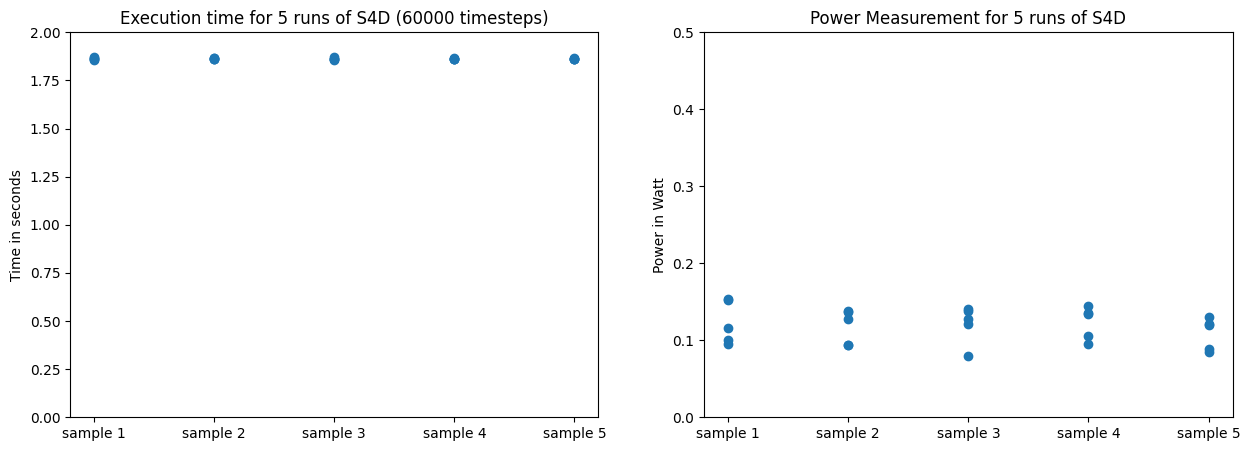

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
a= np.asarray(a).flatten()
total_times = np.asarray(total_times).flatten()
total_energies = np.asarray(total_energies).flatten()
# add yrange
ax[0].set_ylim([0, 2])
ax[0].plot(a, total_times, marker= "o", linestyle = "")
ax[0].set_ylabel("Time in seconds")
ax[0].set_title("Execution time for 5 runs of S4D (60000 timesteps)")
ax[1].plot(a, total_energies, marker= "o", linestyle = "")
ax[1].set_ylim([0, 0.5])
# set y label
ax[1].set_ylabel("Power in Watt")
ax[1].set_title("Power Measurement for 5 runs of S4D")

In [23]:
average_time_per_timestep_in_microseconds = np.mean(total_times) / n_steps * 10 **6
average_power_in_watt = np.mean(total_energies)
print(f"{average_time_per_timestep_in_microseconds=}")
print(f"{average_power_in_watt=}")

average_time_per_timestep_in_microseconds=31.032767999999997
average_power_in_watt=0.11901052


### Measurements for last profiler

Total execution time: 1.865782 s
Total power: 0.130235 W
Total energy: 0.242759 J
Static energy: 0.203177 J


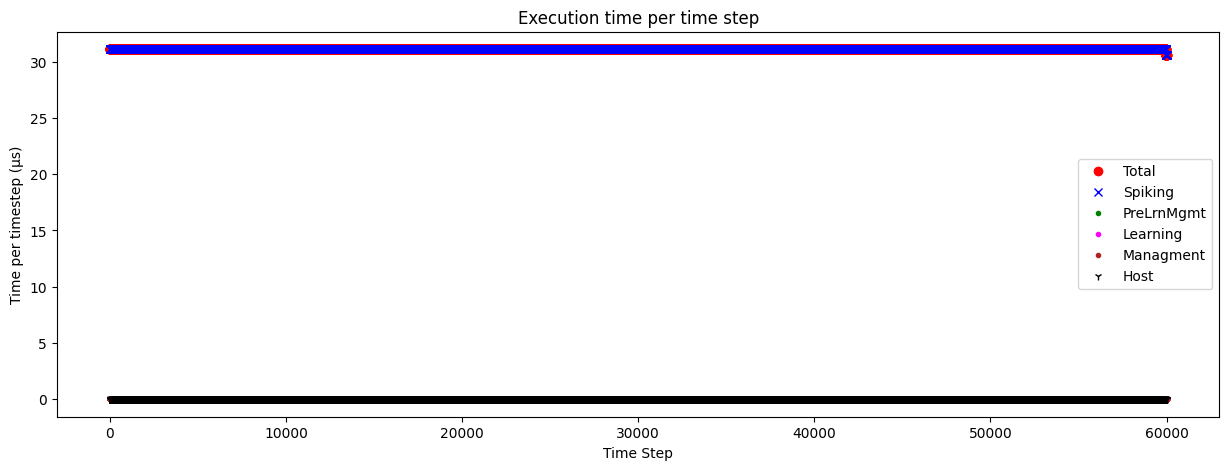

The workload ran on a Loihi 2 system with 1 available chips and occupied 1 chips.
Total Power   : 0.130235 W
Dynamic Power : 0.021235 W
Static Power  : 0.109000 W
VDD Power     : 0.024833 W
VDD-M Power   : 0.043990 W
VDD-IO Power  : 0.061412 W
Total Energy   : 242759.00 µJ
Dynamic Energy : 39582.00 µJ
Static Energy  : 203177.00 µJ
VDD Energy     : 46289.00 µJ
VDD-M Energy   : 81998.00 µJ
VDD-IO Energy  : 114473.00 µJ


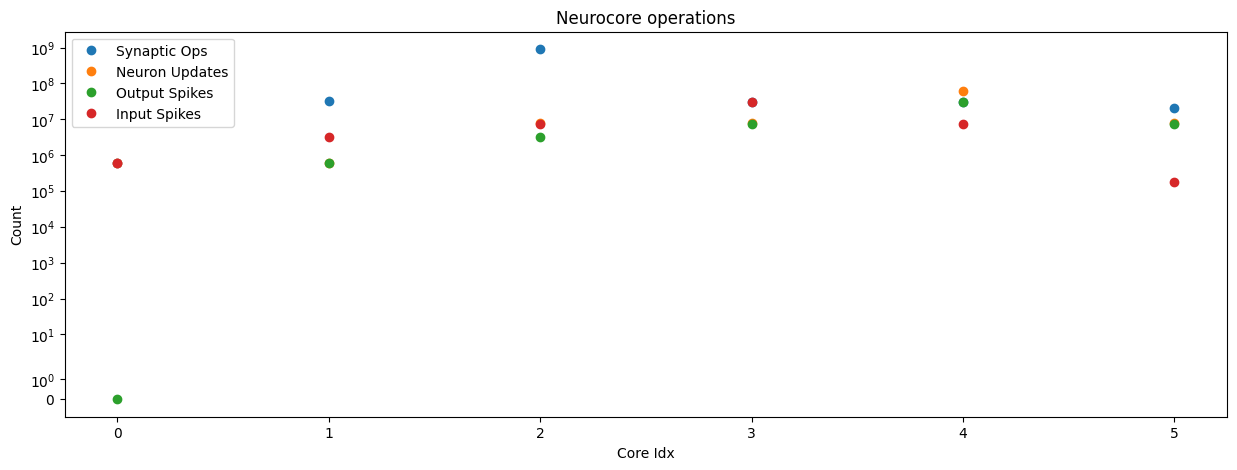

In [24]:
print(f"Total execution time: {np.round(np.sum(time_profiler.execution_time), 6)} s")
print(f"Total power: {np.round(energy_profiler.power, 6)} W") 
print(f"Total energy: {np.round(energy_profiler.energy, 6)} J")
print(f"Static energy: {np.round(energy_profiler.static_energy, 6)} J") 
time_profiler.plot_execution_time()
energy_profiler.statement
energy_profiler.power_breakdown()
energy_profiler.energy_breakdown()
energy_profiler.plot_activity()